# Step 1: Obtain data via quantmod
#Utilize quantmod to load the security symbols

Now that our data frames for AAPL and QQQQ are loaded into memory, let’s extract some prices.


In [1]:
 require(quantmod)
 symbols <- c("AAPL", "QQQ")
 getSymbols(symbols)

Loading required package: quantmod
Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
    As of 0.4-0, 'getSymbols' uses env=parent.frame() and
 auto.assign=TRUE by default.

 This  behavior  will be  phased out in 0.5-0  when the call  will
 default to use auto.assign=FALSE. getOption("getSymbols.env") and 
 getOptions("getSymbols.auto.assign") are now checked for alternate defaults

 This message is shown once per session and may be disabled by setting 
 options("getSymbols.warning4.0"=FALSE). See ?getSymbols for more details.


[1] "AAPL" "QQQ"

# Step 2: Extract prices and time ranges

Notice how we defined and in-sample and out-of-sample range. We will use the in-sample data to compute a simple hedge ratio and then we will apply this hedge ratio to the out of sample data.

In [2]:
 #define training set
 startT  <- "2007-01-01"
 endT    <- "2009-01-01"
 rangeT  <- paste(startT,"::",endT,sep ="")
 tAAPL   <- AAPL[,6][rangeT]
 tQQQQ   <- QQQ[,6][rangeT]
 
 #define out of sample set
 startO  <- "2009-02-01"
 endO    <- "2010-12-01"
 rangeO  <- paste(startO,"::",endO,sep ="")
 oAAPL   <- AAPL[,6][rangeO]
 oQQQQ   <- QQQ[,6][rangeO]

# Step 3: Compute returns and find hedge ratio

In [3]:
 #compute price differences on in-sample data
 pdtAAPL <- diff(tAAPL)[-1]
 pdtQQQQ <- diff(tQQQQ)[-1]
 
 #build the model
 model  <- lm(pdtAAPL ~ pdtQQQQ - 1)
 
 #extract the hedge ratio
 hr     <- as.numeric(model$coefficients[1])

# Step 4: Construct the spread

Let’s look at the distribution of the spread.

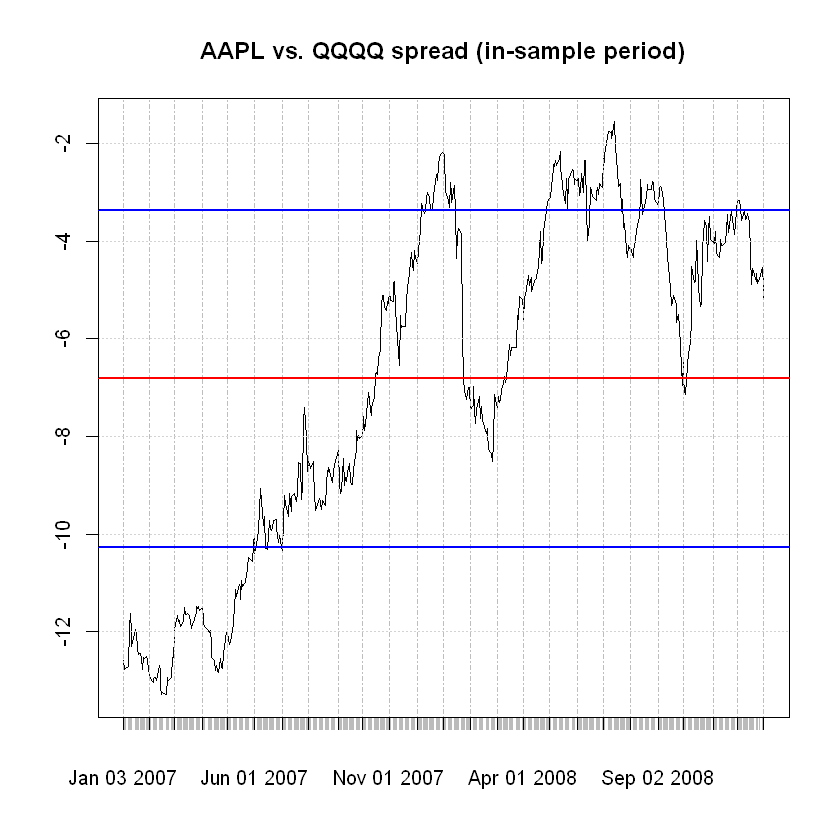

In [4]:
#spread price (in-sample)
 spreadT <- tAAPL - hr * tQQQQ
 
 #compute statistics of the spread
 meanT    <- as.numeric(mean(spreadT,na.rm=TRUE))
 sdT      <- as.numeric(sd(spreadT,na.rm=TRUE))
 upperThr <- meanT + 1 * sdT
 lowerThr <- meanT - 1 * sdT
 
 #visualize the in-sample spread + stats
 plot(spreadT, main = "AAPL vs. QQQQ spread (in-sample period)")
 abline(h = meanT, col = "red", lwd =2)
 abline(h = meanT + 1 * sdT, col = "blue", lwd=2)
 abline(h = meanT - 1 * sdT, col = "blue", lwd=2)


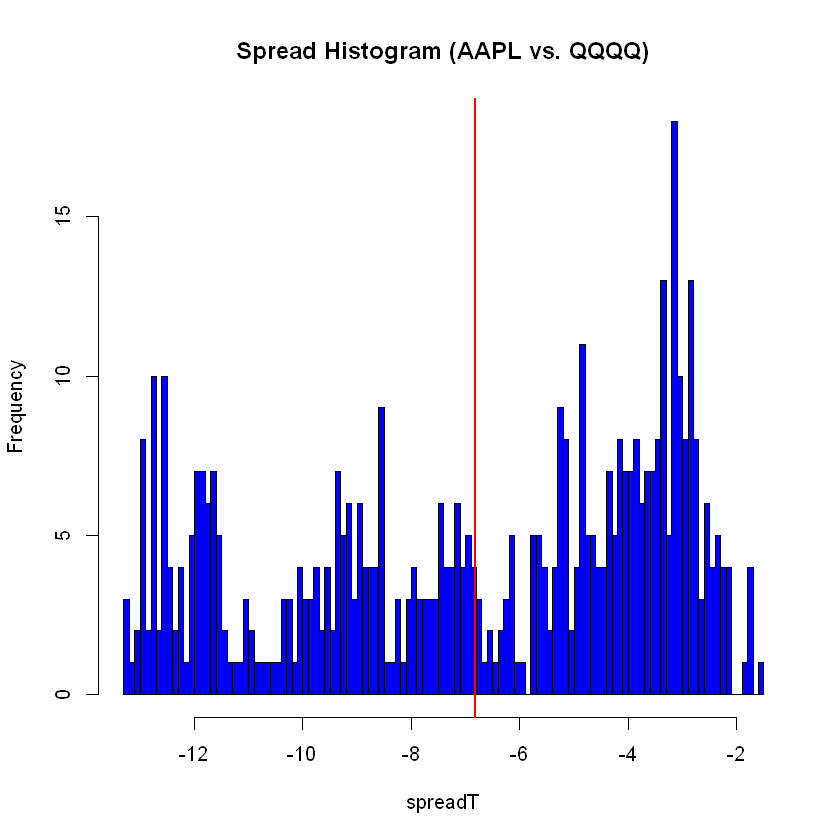

In [5]:
#Let’s look at the distribution of the spread.
hist(spreadT, col = "blue", breaks = 100, main = "Spread Histogram (AAPL vs. QQQQ)")
abline(v = meanT, col = "red", lwd = 2)

Step 5: Define the trading rule

Once the spread exceeds our upper threshold, we sell AAPL and buy QQQQ. Once the spread drops below our lower threshold, we buy AAPL and sell QQQQ.

Step 6: Figure out the trades

Step 7: Visualize trades

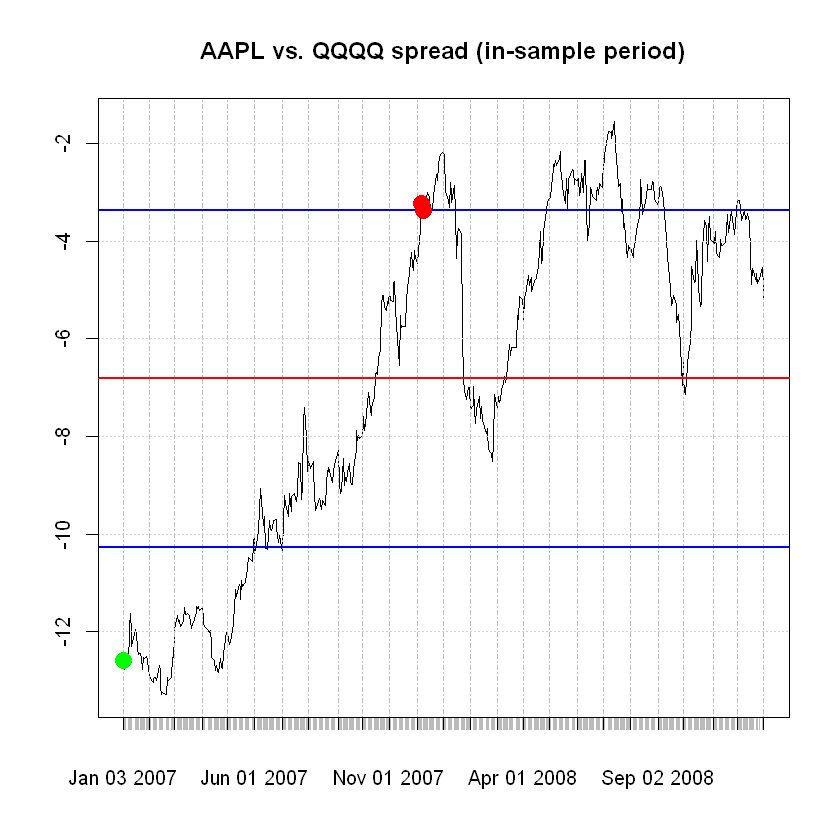

In [6]:
indSell <- which(spreadT >= meanT + sdT)
indBuy  <- which(spreadT <= meanT - sdT)
spreadL  <- length(spreadT)
pricesB  <- c(rep(NA,spreadL))
pricesS  <- c(rep(NA,spreadL))
sp       <- as.numeric(spreadT)
tradeQty <- 100
totalP   <- 0
 
for(i in 1:spreadL) {
 spTemp <- sp[i]
 if(spTemp < lowerThr) {
    if(totalP <= 0){
       totalP     <- totalP + tradeQty
       pricesB[i] <- spTemp
    }
 } else if(spTemp > upperThr) {
   if(totalP >= 0){
      totalP <- totalP - tradeQty
      pricesS[i] <- spTemp
   }
}
}

plot(spreadT, main = "AAPL vs. QQQQ spread (in-sample period)")
abline(h = meanT, col = "red", lwd =2)
abline(h = meanT + 1 * sdT, col = "blue", lwd = 2)
abline(h = meanT - 1 * sdT, col = "blue", lwd = 2)
points(xts(pricesB,index(spreadT)), col="green", cex=1.9, pch=19)
points(xts(pricesS,index(spreadT)), col="red", cex=1.9, pch=19)